# CUNEF MUCD 2022/2023
## Machine Learning
## Análisis de Fraude

### Autores:
- Gozde Yazganoglu
- Irma Sanchez


# Importación de los librerías

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectFromModel, RFE
import category_encoders as ce
from sklearn.linear_model import LogisticRegression, Lasso , Ridge
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

El parte de EDA hemos tratado los datos nulos y comentamos sobre la situacion de outliers. En esta sección vamos a continuar con variable selección y pipelines.

# Seleccion de los Variables y Creacion de Preprocessor

Hemos guardado el data como 'parquet' para que use menos memoria y procese más rapido. 

In [2]:
data= pd.read_parquet('../data/processed/dataset_payments_fraud_processed.parquet')
print("El dataset está compuesto por", len(data.index), "filas y", len(data.columns), "columnas")
data.head()

El dataset está compuesto por 1048575 filas y 19 columnas


,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.0,85,160296.36,capital,138,M1979787155,5,1,0.0,0.0,0
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.0,57,19384.72,country,909,M2044282225,1,0,0.0,0.0,0
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.0,66,0.00,capital,2569,C553264065,10,0,0.0,0.0,1
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.0,31,0.00,country,1787,C38997010,3,0,21182.0,0.0,1
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.0,90,29885.86,country,3997,M1230701703,8,0,0.0,0.0,0


Para poder tratar con pipeline, categorizamos los variables. primero agrupamos los datos numericos.

In [3]:
data_numeric = data.drop(columns = [ 'nameDest','nameOrig', 'type','gender','race','zone', 'device', 'isFraud'])
print("El dataset está compuesto por", len(data_numeric.index), "filas y", len(data_numeric.columns), "columnas")
data_numeric.head()



El dataset está compuesto por 1048575 filas y 11 columnas


,step,amount,connection_time,oldbalanceOrg,age,newbalanceOrig,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest
0,1,9839.64,0.140039,170136.0,85,160296.36,138,5,1,0.0,0.0
1,1,1864.28,0.496890,21249.0,57,19384.72,909,1,0,0.0,0.0
2,1,181.00,0.781150,181.0,66,0.00,2569,10,0,0.0,0.0
3,1,181.00,0.565068,181.0,31,0.00,1787,3,0,21182.0,0.0
4,1,11668.14,0.517114,41554.0,90,29885.86,3997,8,0,0.0,0.0


In [4]:
data_cat = data.filter(items=['nameDest','nameOrig', 'type','gender','race','zone', 'device'])
print("El dataset está compuesto por", len(data_cat.index), "filas y", len(data_cat.columns), "columnas")
data_cat.head()

El dataset está compuesto por 1048575 filas y 7 columnas


,nameDest,nameOrig,type,gender,race,zone,device
0,M1979787155,C1231006815,PAYMENT,man,black,capital,mac
1,M2044282225,C1666544295,PAYMENT,woman,asian,country,mac
2,C553264065,C1305486145,TRANSFER,man,asian,capital,pc
3,C38997010,C840083671,CASH_OUT,man,black,country,mac
4,M1230701703,C2048537720,PAYMENT,unknow,black,country,mac


Ahora conseguimos con variables categoricos. Podemos hacer target encoding o one hot encoding. Este decision es depende de cuantos valores unicos por variable. Tenemos tambien variables tipo numero de cliente : nameDest, nameOrig como comentemos antes, estos variables no nos pueden dar mucha información.

No queremos tampoco ni gender ni race. como hemos mencionado antes, no tiene mucho efecto y tampoco no podemos hacer este tipo de analisis.

In [ ]:
data = data.drop(columns=['nameOrig','nameDest', 'gender','race'])

Primero queremos a ver cual variables son mas importatntes según regressión ridge y lasso. con esta manera podemos seleccionar mejores variables possibles.

# Regresión Logística (Ridge)

La regresión de Ridge se desarrolló como una posible solución a la imprecisión de los estimadores de mínimos cuadrados cuando los modelos de regresión lineal tienen algunas variables independientes multicolineales (altamente correlacionadas), mediante la creación de un estimador de regresión de Ridge (RR). Esto proporciona una estimación más precisa de los parámetros de Ridge, ya que su varianza y estimador cuadrático medio son a menudo más pequeños que los estimadores mínimos cuadrados derivados anteriormente.

In [8]:

#preparing data set for ridge and lasso regressions.



xtrain, xtest, ytrain, ytest = train_test_split(data.drop(columns=['isFraud']),
                                                data['isFraud'],
                                                test_size=0.20, 
                                                random_state=0, 
                                                stratify= data['isFraud'])




list_cat = list(xtrain.select_dtypes("object", "category").columns)
list_num = list(set(xtrain.columns)-set(list_cat))
ohe = ce.OneHotEncoder(cols=list_cat)
model = ohe.fit(xtrain, ytrain)

xtrain_t = model.transform(xtrain, ytrain)
xtest_t = model.transform(xtest, ytest)


scaler = StandardScaler()
model_scaled = scaler.fit(xtrain_t)
X_train_scaled = pd.DataFrame(scaler.transform(xtrain_t), 
                              columns=xtrain_t.columns, 
                              index=xtrain_t.index)
X_test_scaled = pd.DataFrame(scaler.transform(xtest_t),
                             columns=xtest_t.columns,
                             index=xtest_t.index)

In [11]:
#Estsablising the ridge regression and fiting with testdata

sel_ridge = SelectFromModel(LogisticRegression(C=2, penalty='l2'), threshold = 0.01)
sel_ridge.fit(X_train_scaled, ytrain)

SelectFromModel(estimator=LogisticRegression(C=2), threshold=0.01)

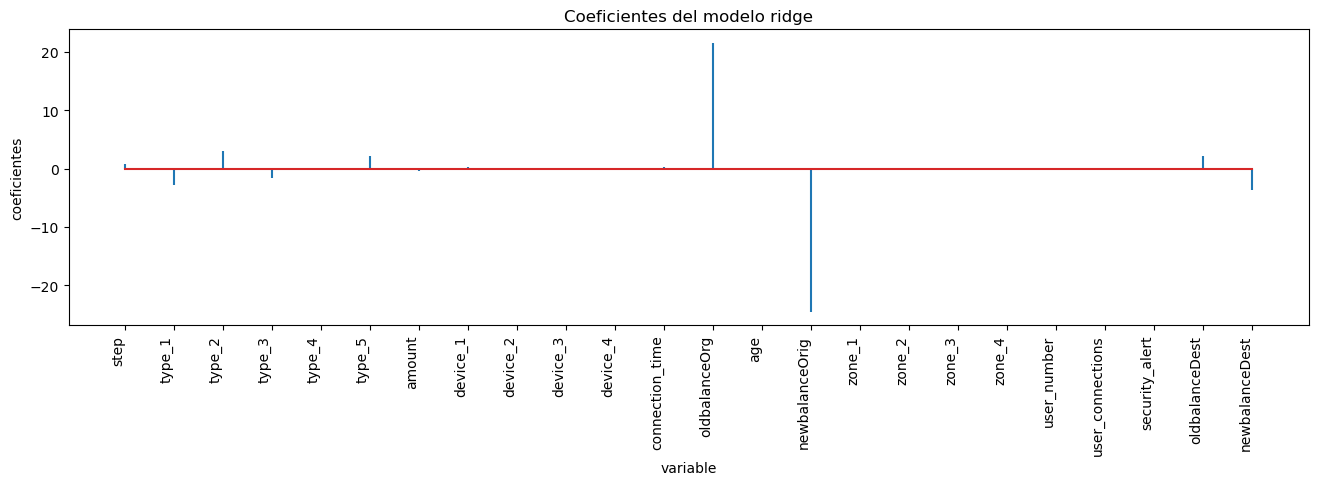

In [12]:
df_coeficientes_ridge = pd.DataFrame(
                        {'predictor': X_train_scaled.columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_ridge.predictor, df_coeficientes_ridge.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [13]:
sel_ridge.get_support()
selected_feat_ridge = X_train_scaled.columns[sel_ridge.get_support()]
selected_feat_ridge

Index(['step', 'type_1', 'type_2', 'type_3', 'type_4', 'type_5', 'amount',
       'device_1', 'device_2', 'device_3', 'device_4', 'connection_time',
       'oldbalanceOrg', 'newbalanceOrig', 'zone_1', 'zone_2', 'zone_3',
       'user_number', 'security_alert', 'oldbalanceDest', 'newbalanceDest'],
      dtype='object')

In [14]:
print('total features: {}'.format((X_train_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat_ridge)))

total features: 24
selected features: 21


Ridge Regression nos selecciona 21 variables de 24. Los variables cantidad de dinero en cuentas, tienen mas importancia.

# Regresión Logística (Lasso)

La regresión de Lasso es parecida La la regresión lineal, pero utiliza una técnica de "contracción" en la que los coeficientes de determinación se reducen La cero . 
La regresión lineal le brinda coeficientes de regresión como se observa en el conjunto de datos. La regresión Lasso le permite reducir o regularizar estos coeficientes para evitar el sobreajuste y hacer que funcionen mejor en diferentes conjuntos de datos. 
Este tipo de regresión se usa cuando el conjunto de datos muestra una alta multicolinealidad o cuando desea automatizar la eliminación de variables y la selección de características .

In [15]:
# Establishing the model and fiting with training set.
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'), threshold = 0.08) 
sel_lasso.fit(X_train_scaled, ytrain)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.08)

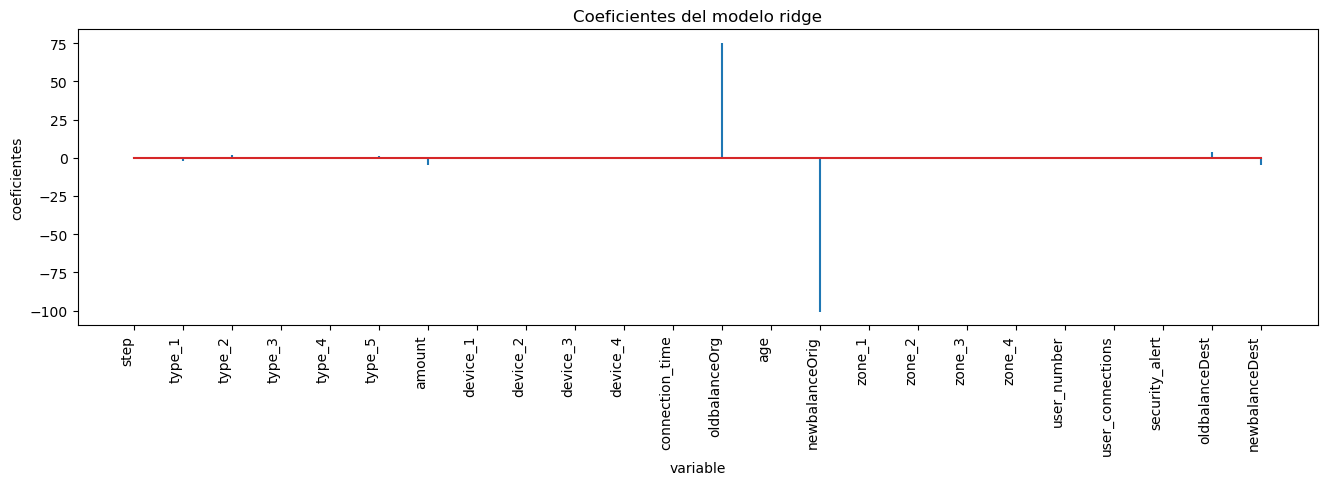

In [16]:
#now let's see on a graph
df_coeficientes_lasso = pd.DataFrame(
                        {'predictor': X_train_scaled.columns,
                         'coef': sel_lasso.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes_lasso.predictor, df_coeficientes_lasso.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [30]:
sel_lasso.get_support()
selected_feat_lasso = X_train_scaled.columns[sel_lasso.get_support()]
selected_feat_lasso

Index(['step', 'type_1', 'type_2', 'type_4', 'type_5', 'amount', 'device_2',
       'device_4', 'connection_time', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest'],
      dtype='object')

In [31]:
print('total features: {}'.format((X_train_scaled.shape[1])))
print('selected features: {}'.format(len(selected_feat_lasso)))

total features: 24
selected features: 13


Lasso nos dejo elegir 13 de 24 variables. En este analisis vamos a elegir Ridge selection para poder evitar perdida de informacion.

# Pipelines

Para poder analizar en siguentes pasos, vamos a preparar otro pipeline y vamos a guardar en pickle por siguentes anallisises. 

In [32]:
list_cat = ['type','zone', 'device']

In [33]:
list_num = ['step','amount','connection_time','oldbalanceOrg','age', 'newbalanceOrig','user_number','user_connections','security_alert','oldbalanceDest','newbalanceDest']

In [34]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])


onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=np.nan)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, list_num),
        ('cat', onehot_transformer, list_cat)
        ])

In [36]:
# Guardamos el preprocessor
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)

El preprocessador se va utilizar en siguentos pasos. en esta manera podemos utilizar en futuro con nuevos datos introducidos para comprobar con modelos.

# Creaccion de los datos de Train y Test

In [37]:
xtrain, xtest, ytrain, ytest = train_test_split(data.drop(columns=['isFraud']), data['isFraud'], test_size=0.20, random_state=0, stratify= data['isFraud'])

In [38]:
print("El dataset está compuesto por", len(xtrain.index), "filas y", len(xtrain.columns), "columnas")
xtrain.head()

El dataset está compuesto por 838860 filas y 14 columnas


,step,type,amount,device,connection_time,oldbalanceOrg,age,newbalanceOrig,zone,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest
398013,18,PAYMENT,18122.77,iphone,0.203923,51886.00,44,33763.23,africa,2047,10,0,0.00,0.00
57644,9,CASH_OUT,162508.35,pc,0.811282,35137.00,18,0.00,capital,881,2,0,19824.00,437067.20
112607,11,PAYMENT,4531.20,pc,0.809820,85289.39,67,80758.19,africa,1769,4,0,0.00,0.00
438762,18,CASH_OUT,133330.40,pc,0.822840,0.00,25,0.00,country,2369,7,0,1989858.29,2789940.33
734829,38,CASH_IN,1937.66,mac,0.462285,3515915.02,52,3517852.68,country,4838,1,0,1506327.42,1748125.69


In [39]:
print("El dataset está compuesto por", len(xtest.index), "filas y", len(xtest.columns), "columnas")
xtest.head()

El dataset está compuesto por 209715 filas y 14 columnas


,step,type,amount,device,connection_time,oldbalanceOrg,age,newbalanceOrig,zone,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest
913673,43,CASH_OUT,183961.06,iphone,0.188162,10110.00,14,0.00,country,4304,7,0,3065000.46,3248961.52
217560,13,CASH_OUT,116454.41,mac,0.381502,231298.00,23,114843.59,africa,4689,3,0,883739.58,1000193.98
738438,38,CASH_IN,177780.66,mac,0.453677,2820628.04,83,2998408.71,country,3408,10,0,990784.88,813004.21
632204,35,PAYMENT,16824.94,other,0.925336,337204.00,83,320379.06,africa,1524,10,0,0.00,0.00
529704,20,CASH_IN,109133.06,iphone,0.018892,17106267.15,45,17215400.22,country,1458,9,1,6624653.56,6515520.50


Elegimos test size como 20% luego para comprobar con los modelos. Como tenemos un problema de minoridad, Es importante que barajar bien los valores. Hemos puesto stratify = ['isFraud'] para valores objectivos. Para asegurar, hacemos otro analisis rapida para observar si hemos seperado bien.

In [40]:
import sweetviz as sv

In [41]:
#compare_report = sv.compare([xtrain, "train"],[xtest, "test"])
#compare_report.show_html("../html/compare_variables.html")

#Comentamos el codigo porque se trabaja mejor así. 
#El resultado esta en htmls. En caso de necesidad se puede executar también.

El reporte de comparacion nos enseña que los datos de training son seperado bien. podemos conseguir con esta separacion. Cuando seperar elegimos stratif= data['isFraud'] para ayudarnos tener 2 sets en más o menos mismo proporciones de valores 1. En este trabajo no trabajamos con datos sinteticos para evitar sus desventajas.

In [42]:
xtrain.to_parquet("../data/processed/xtrain.parquet")
xtest.to_parquet("../data/processed/xtest.parquet")
pd.DataFrame(ytrain).to_parquet("../data/processed/ytrain.parquet")
pd.DataFrame(ytest).to_parquet("../data/processed/ytest.parquet")
print('guardado')


guardado
